## Modelling

### Content:

1. Variable selection
2. Model 1: linear regression with 6 variables
3. Model 2: linear regression with 9 variables
4. Model 3: Ridge regression with 9 variables
5. Model 4: KNN with 9 variables. (optimal k = 2)
6. Model 5: decision tree with 9 variable. (optimal depeth is 4)


In [215]:
import requests
import json
import pandas as pd
import re
import math
import warnings
warnings.filterwarnings('ignore')
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_columns', 50) # show all columns
pd.set_option('display.max_rows', 500) # show all rows
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import neighbors
from math import sqrt
from sklearn.metrics import mean_squared_error 
from yellowbrick.regressor import ResidualsPlot
from sklearn.tree import DecisionTreeRegressor

In [216]:
df = pd.read_csv('../data/final_data2.csv')

In [217]:
df.isnull().sum()

LOCATION                          0
TIME                              0
Value_disposable_income           5
Value_adult_education             2
Value_alcohol_consumption         0
Value_air_pollution               0
Value_overweight_population      41
Value_avg_annual_hours            8
Happiness Rank                    0
HDI Rank (2017)                  86
income_inequality                 0
unemployment                      0
HDI_value                         3
Region                            0
Happiness Score                   0
Economy (GDP per Capita)          0
Family                            0
Health (Life Expectancy)          0
Freedom                           0
Trust (Government Corruption)     0
Generosity                        0
Dystopia Residual                 0
dtype: int64

## Variable selection

- We will not use 'HDI Rank (2017)' and 'Value_overweight_population' columns as predictors in the model since too much missing value and hard to fill-in. 
- Delete  happiness rank, as it shows same information as happincess score, as we have jusified before
- fill left few missing points using the mean of that column
- Draw scatter plot of target and each features to pick reasonable features  
    From the sactter plot above, we can see that：
     - Most variables have linear relationship with our target 'happiness score'. Thus, these variales are reasonable to be picked for OLS regressor. 
     - `'Value_adult_education'`, `Value_alcohol_consumption`， `Value_air_pollution`,`unemployment`,`income_inequality` looks have no 'clear' linear relationship with happiness score. So I willnot use them in the linear regression.

In [218]:
del df['HDI Rank (2017)']
del df['Value_overweight_population']
del df['Happiness Rank']

# fill the few missing point using the mean of that column
df['Value_adult_education'].fillna((df['Value_adult_education'].mean()), inplace=True)
df['Value_avg_annual_hours'].fillna((df['Value_avg_annual_hours'].mean()), inplace=True)
df['HDI_value'].fillna((df['HDI_value'].mean()), inplace=True)
df['Value_disposable_income'].fillna((df['Value_disposable_income'].mean()), inplace=True)

df.isnull().sum() # no missing value now!

LOCATION                         0
TIME                             0
Value_disposable_income          0
Value_adult_education            0
Value_alcohol_consumption        0
Value_air_pollution              0
Value_avg_annual_hours           0
income_inequality                0
unemployment                     0
HDI_value                        0
Region                           0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64

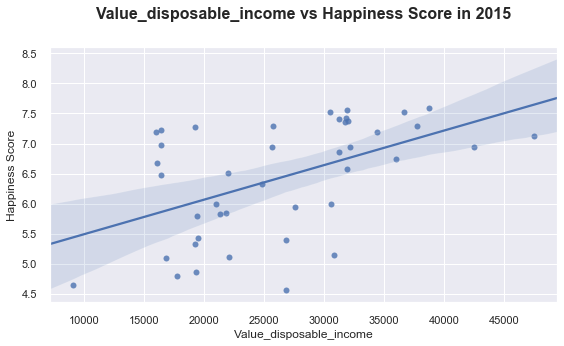

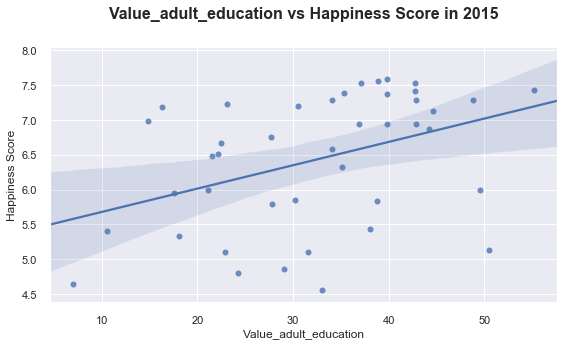

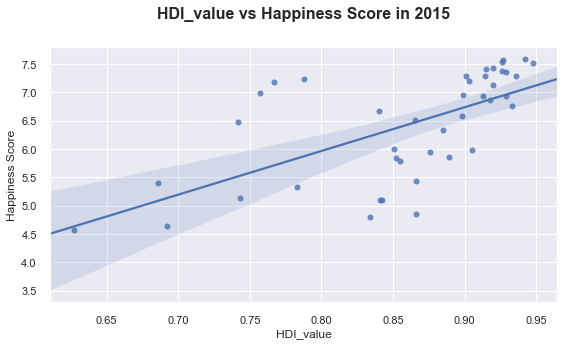

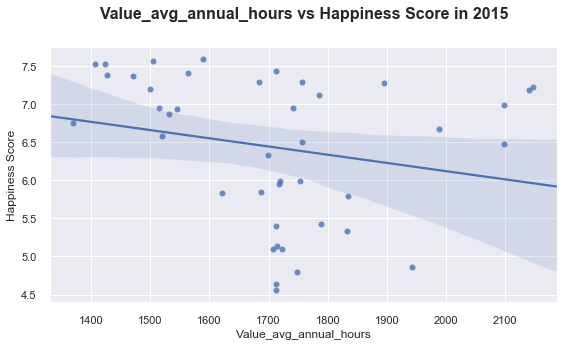

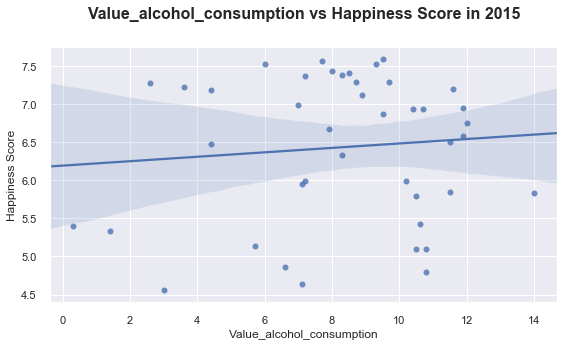

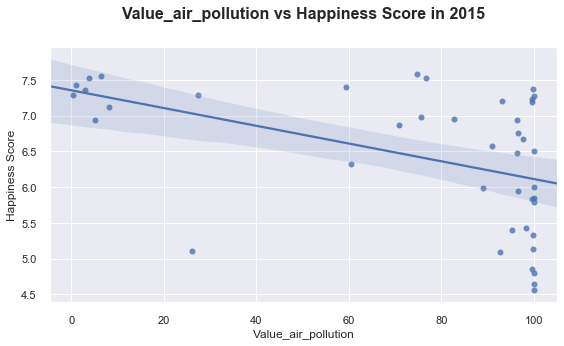

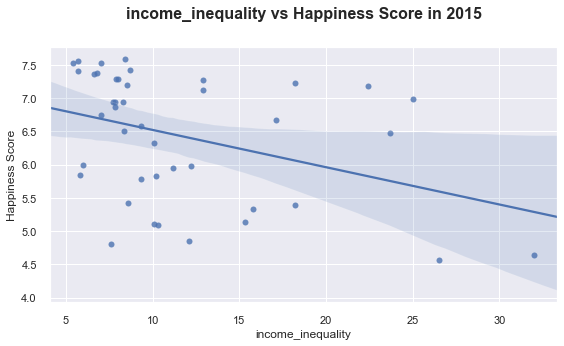

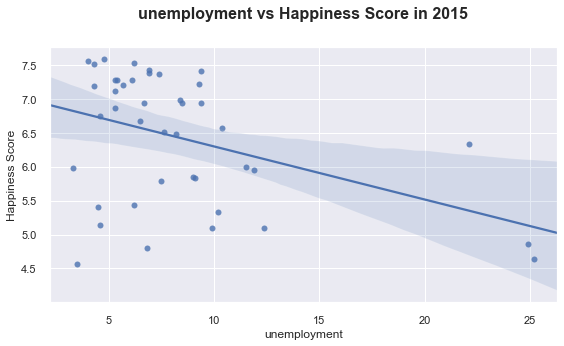

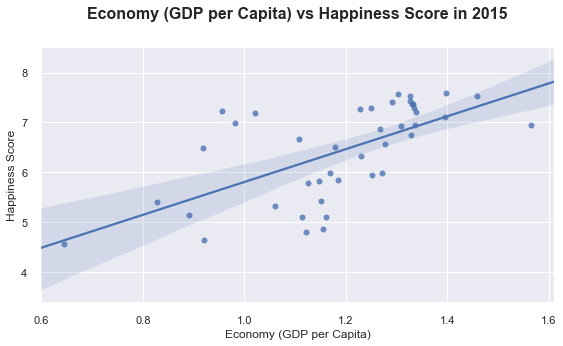

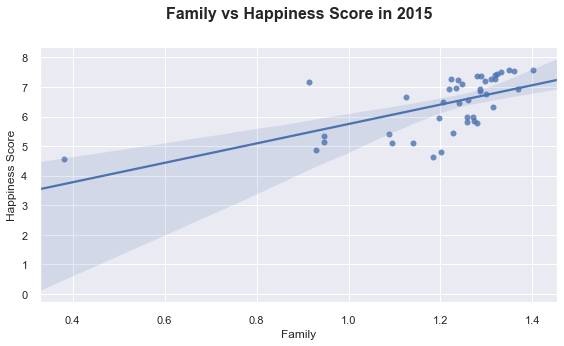

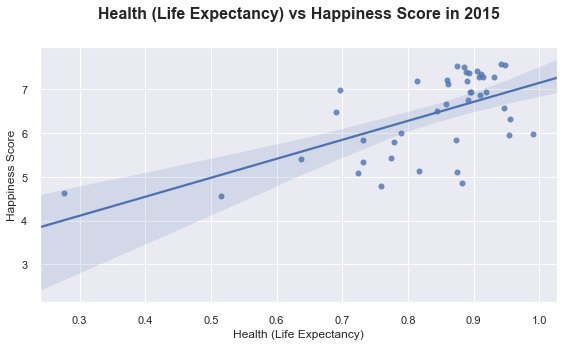

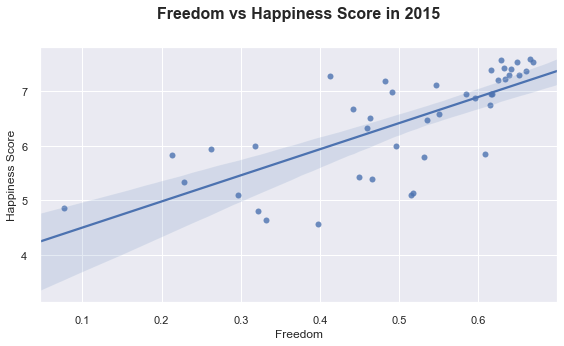

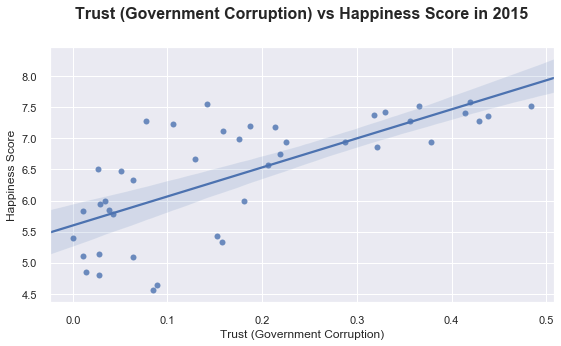

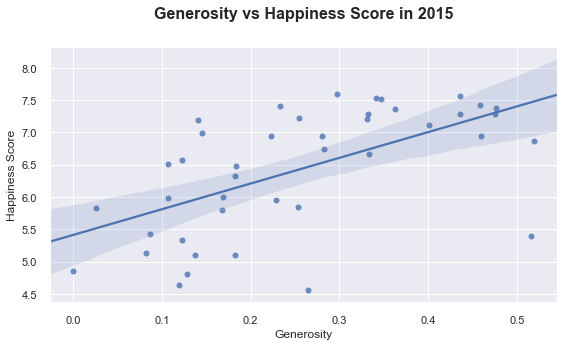

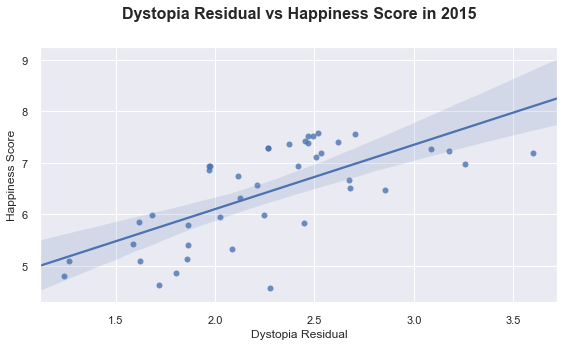

In [219]:
## Draw plots to check if linear relationship exists between
possible_features = [
        'Value_disposable_income','Value_adult_education',
         'HDI_value','Value_avg_annual_hours',
        'Value_alcohol_consumption', 'Value_air_pollution',
        'income_inequality',
       'unemployment', 
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity','Dystopia Residual']

for feature in possible_features:
    fig, ax = plt.subplots(figsize=(8,5))
    title = feature + " vs Happiness Score in 2015"
    ax = sns.regplot(x=feature, y="Happiness Score", data=df[df['TIME']==2015])
    #sns.scatterplot("Happiness Rank","Happiness Score", hue = 'TIME', data=df)
    ax.text(x=0.5, y=1.1, s=title, fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    fig.tight_layout()
    plt.show()

### Split train and test dataset
- We use 2015 and 2016 data as trainset
- 2017 data for testing

In [220]:
train = df[df['TIME']!=2017]
test = df[df['TIME']==2017]

In [221]:
print(len(train)/(len(train)+len(test)))

0.6746031746031746


Thus, around 67% data in train set

In [222]:
# the features we will use in model1, our baseline
features_group1 = ['Economy (GDP per Capita)', 'Family','Health (Life Expectancy)','Freedom',
                   'Trust (Government Corruption)','Generosity']

## More features, which have linear relationship with happiness score
features_group2 = [
         'Value_disposable_income',
         'Value_avg_annual_hours',
         'HDI_value',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity']

In [223]:
X_train = train[features_group1]
X_test = test[features_group1]

X_train_more = train[features_group2]
X_test_more = test[features_group2]  # 16 features


y_train = train['Happiness Score']
y_test = test['Happiness Score']

y_test = y_test.as_matrix() 

In [224]:
df['Happiness Score'].corr(df['Dystopia Residual'])

0.5968725731630378

## Normalization variables

In [225]:
def normalize(features_group, X_train, X_test):
    for feature in features_group:
         ### get mean and std from train dataset
        (mu_train, sigma_train) = norm.fit(X_train[feature])
        ### normalization this feature
        X_train[feature] = (X_train[feature] - mu_train) / sigma_train
        X_test[feature] = (X_test[feature] - mu_train) / sigma_train
    
    return X_train, X_test

In [226]:
X_train, X_test = normalize(features_group1, X_train, X_test)
X_train_more, X_test_more = normalize(features_group2, X_train_more, X_test_more)

In [227]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Model 1: linear regression with 6 variables 
features are 'Economy (GDP per Capita)', 'Family','Health (Life Expectancy)','Freedom',
                   'Trust (Government Corruption)','Generosity'

Intercept: 
 6.429870588235295
Coefficients: 
 [0.16386333 0.09048387 0.18947022 0.16933201 0.24582693 0.17241785]
coefficient of determination: 
 0.7167053233539813

---------------Evaluation----------------------------------
explained_variance:  0.6779
mean_squared_log_error:  0.0038
r2:  0.6605
MAE:  0.3579
MSE:  0.1969
RMSE:  0.4438


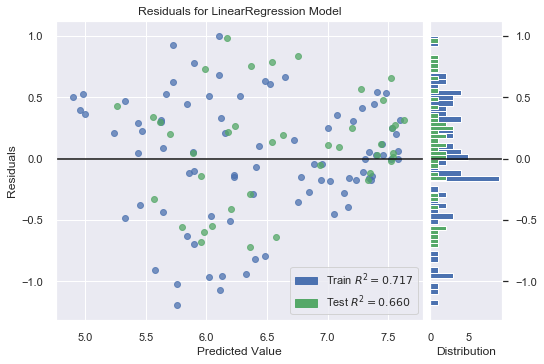

In [228]:
lr = LinearRegression()
lr.fit(X_train, y_train)


print('Intercept: \n', lr.intercept_)
print('Coefficients: \n', lr.coef_)
r_sq = lr.score(X_train, y_train)
print('coefficient of determination: \n', r_sq)

print("\n---------------Evaluation----------------------------------")
y_pred = lr.predict(X_test) # predict
regression_results(y_test, y_pred)

#### Create Residual Plots
visualizer = ResidualsPlot(lr)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#pred_actual_table

## Model 2: Linear regression with 11 variables
We include more information, and want to see if can get better result

Intercept: 
 6.429870588235295
Coefficients: 
 [ 0.03007891  0.32794705 -0.03625589  0.3213795   0.12913119  0.15181011
  0.20508455  0.27192656  0.20167089]
coefficient of determination: 
 0.7954810339651777

---------------Evaluation----------------------------------
explained_variance:  0.7488
mean_squared_log_error:  0.004
r2:  0.6237
MAE:  0.3471
MSE:  0.2183
RMSE:  0.4672


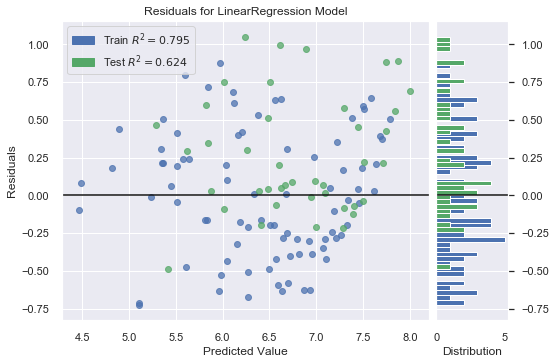

In [229]:
lr2 = LinearRegression()
lr2.fit(X_train_more, y_train)


print('Intercept: \n', lr2.intercept_)
print('Coefficients: \n', lr2.coef_)
r_sq = lr2.score(X_train_more, y_train)
print('coefficient of determination: \n', r_sq)

print("\n---------------Evaluation----------------------------------")
y_pred = lr2.predict(X_test_more) # predict
regression_results(y_test, y_pred)

#### Create Residual Plots
visualizer = ResidualsPlot(lr2)
visualizer.fit(X_train_more, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_more, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#pred_actual_table

No, thus we consider add penalty factor to model

## Model 3: Ridge regression with  9 variables
Linear least squares with l2 regularization.
reason:
- Ridge Regression is a technique used when the data suffers from **multicollinearity** (independent variables are highly correlated). 
- when has more than features.

#### Estimate shrinkage parameter 
find best lambda

In [230]:
alphas = np.arange(0.001, 1, 0.001).tolist()

Intercept: 
 6.429870588235295
Coefficients: 
 [0.0363918  0.3245734  0.00957119 0.28562982 0.12182155 0.1364998
 0.20565858 0.268557   0.19743903]
coefficient of determination: 
 0.7952648597896144
explained_variance:  0.7515
mean_squared_log_error:  0.0038
r2:  0.6463
MAE:  0.3359
MSE:  0.2052
RMSE:  0.4529


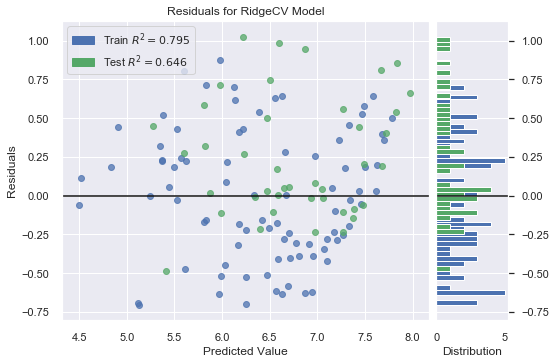

In [231]:
clf = RidgeCV(alphas=alphas) # use Cross-validation to select best lambda
clf.fit(X_train_more, y_train) 

print('Intercept: \n', clf.intercept_)
print('Coefficients: \n', clf.coef_)
r_sq = clf.score(X_train_more, y_train)
print('coefficient of determination: \n', r_sq)


y_pred = clf.predict(X_test_more) # predict
regression_results(y_test, y_pred)

#### Create Residual Plots
visualizer = ResidualsPlot(clf)
visualizer.fit(X_train_more, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_more, y_test)  # Evaluate the model on the test data
visualizer.show()  

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#pred_actual_table

## Model 5: KNN with 9 variables
Since no clear linear pattern, so we try KNN to see if can get better result

In [232]:
rmse_val = [0] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_more, y_train)  #fit the model
    y_pred=model.predict(X_test_more)#make prediction on test set
    error = sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.35719597060063735
RMSE value for k=  2 is: 0.29033207682518697
RMSE value for k=  3 is: 0.3266639313371375
RMSE value for k=  4 is: 0.3355196505472286
RMSE value for k=  5 is: 0.33897732287579524
RMSE value for k=  6 is: 0.3766154996482416
RMSE value for k=  7 is: 0.3858992580073217
RMSE value for k=  8 is: 0.36402667630922847
RMSE value for k=  9 is: 0.3528215848141613
RMSE value for k=  10 is: 0.36792742089936253
RMSE value for k=  11 is: 0.37776467746372283
RMSE value for k=  12 is: 0.3756257536471796
RMSE value for k=  13 is: 0.38644407834512384
RMSE value for k=  14 is: 0.38321780067538774
RMSE value for k=  15 is: 0.3987290351288236
RMSE value for k=  16 is: 0.40997791482516954
RMSE value for k=  17 is: 0.41567357108770414
RMSE value for k=  18 is: 0.4213005421093617
RMSE value for k=  19 is: 0.41825201541985735
RMSE value for k=  20 is: 0.4170105665410165


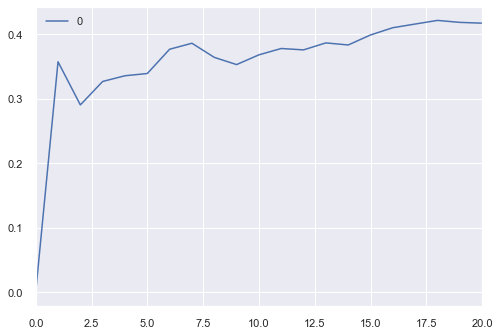

In [233]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

Thus , best K is k = 2. But k = 2 is apparently overfitting. 

coefficient of determination: 
 0.9122332464644138

---------------Evaluation----------------------------------
explained_variance:  0.8681
mean_squared_log_error:  0.0017
r2:  0.8547
MAE:  0.2202
MSE:  0.0843
RMSE:  0.2903


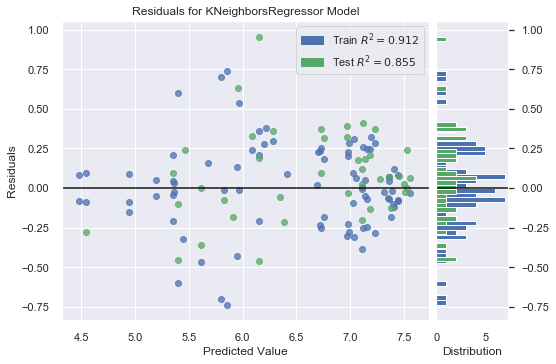

,Actual,Predicted
0,7.284,7.3555
1,7.006,6.9750
2,6.891,7.0685
3,7.316,7.1835
4,6.652,6.9740
5,6.609,6.1480
6,6.951,7.1360
7,7.522,7.5245
8,6.403,6.3450
9,5.611,5.6100


In [234]:
lr3 = neighbors.KNeighborsRegressor(n_neighbors = 2)  # select k = 1
lr3.fit(X_train_more, y_train)


#print('Intercept: \n', lr3.intercept_)
#print('Coefficients: \n', lr3.coef_)
r_sq = lr3.score(X_train_more, y_train)
print('coefficient of determination: \n', r_sq)

print("\n---------------Evaluation----------------------------------")
y_pred = lr3.predict(X_test_more) # predict
regression_results(y_test, y_pred)

#### Create Residual Plots
visualizer = ResidualsPlot(lr3)
visualizer.fit(X_train_more, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_more, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_actual_table

### Model: decision tree

In [235]:
#### find optimal depth:
for depth in range(1, 20):
    decision_tree = DecisionTreeRegressor(random_state = 0,max_depth= depth)  
    decision_tree.fit(X_train_more, y_train)
    y_pred = decision_tree.predict(X_test_more) # predict
    r2=metrics.r2_score(y_test, y_pred)
    mse=metrics.mean_squared_error(y_test, y_pred) 
    print("Max_depth: {}, R square is: {}, mse is {}".format(depth, r2, mse))

Max_depth: 1, R square is: 0.5260865951476776, mse is 0.2748737655824519
Max_depth: 2, R square is: 0.7041954609568565, mse is 0.17156912357967
Max_depth: 3, R square is: 0.72063450980992, mse is 0.16203433681362872
Max_depth: 4, R square is: 0.7896227249207102, mse is 0.12202059110786165
Max_depth: 5, R square is: 0.7550881961529063, mse is 0.14205090860432443
Max_depth: 6, R square is: 0.727938865909745, mse is 0.1577977487666211
Max_depth: 7, R square is: 0.6859983561330821, mse is 0.18212359761310257
Max_depth: 8, R square is: 0.6732998794346994, mse is 0.18948882103051817
Max_depth: 9, R square is: 0.7219206085852903, mse is 0.16128838869383005
Max_depth: 10, R square is: 0.6715519141572877, mse is 0.19050265561082352
Max_depth: 11, R square is: 0.698401524600226, mse is 0.17492965545656083
Max_depth: 12, R square is: 0.6787220401639469, mse is 0.1863439221481876
Max_depth: 13, R square is: 0.6787220401639469, mse is 0.1863439221481876
Max_depth: 14, R square is: 0.678722040163946

Based on the result above, the optimal depth is 4.

coefficient of determination: 
 0.9463654860517159

---------------Evaluation----------------------------------
explained_variance:  0.797
mean_squared_log_error:  0.0025
r2:  0.7896
MAE:  0.2359
MSE:  0.122
RMSE:  0.3493


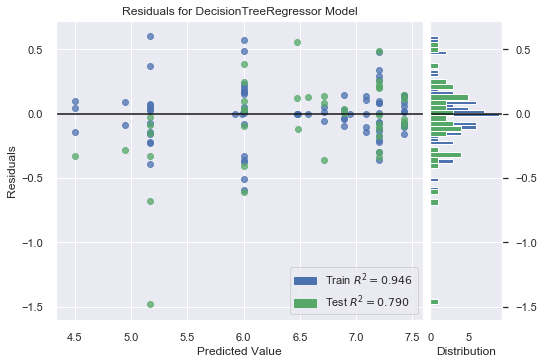

In [241]:
decision_tree = DecisionTreeRegressor(random_state = 0,max_depth=4)  
decision_tree.fit(X_train_more, y_train)


#print('Intercept: \n', lr3.intercept_)
#print('Coefficients: \n', lr3.coef_)
r_sq = decision_tree.score(X_train_more, y_train)
print('coefficient of determination: \n', r_sq)

print("\n---------------Evaluation----------------------------------")
y_pred = decision_tree.predict(X_test_more) # predict
regression_results(y_test, y_pred)

#### Create Residual Plots
visualizer = ResidualsPlot(decision_tree)
visualizer.fit(X_train_more, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_more, y_test)  # Evaluate the model on the test data
visualizer.show()   

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#pred_actual_table